<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>CS 144 - Spring 2021 - Gene Finding</h1></center>
<center><h1>Due: Sunday, June 6th, 2021 @ 11:59pm</h1></center>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Charles Ho <br>
    Your student ID (submitter): 
<br>
<br>
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
<br>    
<br>
<b>Instruction for submissions:</B> when you have completed this project, download this .ipynb file to your computer by left-clicking on the file name, and submit to <a href="https://elearn.ucr.edu/">Canvas</A> by the deadline. 
<br>
<br>
<B>Late work:</B> There is no late deadline for the final project, except for the most serious circumstances (illness, medical emergency, etc.) which have to be documented.
</div>


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Gene finding in the BD genome</h1></center>
<br>

The objective of this project is to find genes in a real genome (called BD) by analyzing real RNA-Seq data. The <i>BD</i> genome sequence is not available, and as far as I know, nobody knows where the genes are. <i>BD</i> is an a infectious parasite that causes a disease in human similar to Lyme disease. Both diseases are transmitted to humans through the bite of an infected tick. Finding the genes in <i>BD</i>  is crucial in our efforts to develop new drugs to prevent this parasite from harming humans.

The genome assembly of <i>BD</i> was assembled in my lab from Pacific Bioscence HiFi reads, the latest technology for DNA sequencing. We believe that <i>BD</i> has four/five chromosomes, but we are not sure yet. The assembly is currently broken up into nine contigs, some of which could be complete chromosomes but we are not sure either. The RNA-Seq reads are Pacific Bioscence IsoSeq, which is the latest third-generation sequencing technology to generate full-length cDNA sequences to characterize transcript isoforms across an entire transcriptome.

This project is somewhat open-ended, and is suitable only for students who is willing to invest more time that the other projects. Other than having fun working with a real research problem, your ideas could generate a new method in bioinformatics (i.e., this is as close to research as you will get in this class). In order to discover the genes you will have to come up with your own algorithm. You can discuss your initial idea with me, but you will responsible to justify your design choices. Your algorithm has to run in a reasonable amount of time (at least on the smallest BD chromosome) so that you can demonstrate it during the demo.

I will provide you with our best guess where the genes are, so that you compare the results on your method against our gene predictions.

First, let's get the data using wget. The file `BD.fa` is the genome (in FASTA format), while the file `transcripts.fastq` contains the transcripts (FASTQ format). Please run the code below only once or you will end up with a lot of copies of these files.

In [1]:
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/BD.fa
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/transcripts.fastq

--2021-06-06 23:04:16--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/BD.fa
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7485275 (7.1M)
Saving to: ‘BD.fa’

BD.fa               100%[===================>]   7.14M  --.-KB/s    in 0.1s    

2021-06-06 23:04:17 (56.4 MB/s) - ‘BD.fa’ saved [7485275/7485275]

--2021-06-06 23:04:17--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/transcripts.fastq
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185603909 (177M)
Saving to: ‘transcripts.fastq’

transcripts.fastq   100%[===================>] 177.00M  71.6MB/s    in 2.5s    

2021-06-06 23:04:19 (71.6 MB/s) - ‘transcripts.fastq’ saved [185603909/185603909]



Let's take a quick look at the content of these files using `head`. You can also use the JupyterLab Launcher to open a terminal, navigate to the directory where these files are located and type `less transcripts.fastq` or `less BD.fa`. Observe that the genome is in FASTA format (read this <A href="https://en.wikipedia.org/wiki/FASTA_format">link</A> for a description) while the transcripts are in FASTQ format (read this <A href="https://en.wikipedia.org/wiki/FASTQ_format">link</A> for a description). You can use Biophyton to parse FASTA or FASTQ. Observe that the trascripts have quality scores.

In [2]:
!head BD.fa

>contig1
CCAGACTTGCCCTCCAATTGATACTCTGGAAGGGGTTTGGATTCCCATCATTCCAATTAC
AAAGCTTTAAGCCCTGTATTGTTATTTCTTGTCACTACCTCACGGTGTCCGTATTGGGTA
ATTTGCGCGCCTGCTGCCTTCCTTAGATGTGGTAGCCGTTTCTCAGGCTCCCTCTCCGGA
ATCGAACCCTAATTCCCCGTTACCCGTCGCTGCCCCGGTAGGCCAATACCCTACCGTCCA
AAGCTGATAGGTCAGAAACTTGAATGAACCATCGCCGGCAAAAGCCATGCGATTCGCAAA
TTTATTATGAATCACCGAGTACCGCAAGCGGGAAGGTTTCGAGTCTAATAAACGCAGCCA
AGACAGGAGCCAAGGCCTCGAGCATGTATTAGCCCTACAATTAGCACGGTTATCCATGTA
AAAACGACTTTCAAATAAACTATAACTGTTGTAATGAGCCATTCGCAGTTTCACCATATA
AAAGTTTATACTTAGACATGCATGGCTTAATCTTTAAGACAAGCATATGACTACTGGCAG


In [3]:
!head transcripts.fastq

@UnnamedSample_HQ_transcript/0
GACTCGGAATAAAATGCCAAGTGATGCATTTGCCGATATTTTGTAAAAATGGTCATGAATTTGGTTCAAGCTTCACATTCGCTGCAAACTAAATGAAGGATTCCGTTTTTTCATTAAAGGATACCTCAAAGGTTCCTACAAGTGAGGAAAACCTTGAAAAGTACTGTAGCATATTAAAACGATTACAATCAGATTCTCTAGGCAATAGTATTAACAGTAGCAATATCAAATTTCAACAAGGTGATCCTGGATATACAGGACTTCCACCTCGAGTGAATGAGGAGAAAATTGTAACCATTGAAATTGAACGTTGTAGAATCTCTTTAACATTTCTAAAGCGGCTACTGACAAGTAATGAAGATGCTTCCATTGGTATTCTAACACGTGTGTTGTGTGATGATGAAATTATATCAAAATTGCTTGCATGCGGAAAGAATTTTAAATTGGGGCTTGTTAGAGATTTACCTGATGATATCAATGCTGATTTATCACAGGCCATTAAGGACGCTACTGAGGTCTTTAATGGTCAATTGATACCATTTGTAATGTGGCCTGGTAGCAATTTTAAAGTTGACCAATCTGTGGTTTTTGATGCCTTGCAGATTTACAGGCTTTTAAAATTTAATCGCAGCATATTCGTTGAAGTTGGACGCAATGTTGCCTTTTCACACGACCAAGGTGGTCCAATTGCGGTGGATTTATCCAATCCATTTATTCTTCAGGAATTGGCGGATGTAATTTTGGATGAATTATTGGCATCCCTTGAATGCCTTCAACTCTTGGCGGTTAATTGTATGAACTTTACAGATGGAACCTTGGCAATGCATTGTAAATCCATTTTAGTGCAACAGGATTTTCCCGAAATGTTATGGAACTTGTACAAGGCTCTTGACAATTTTGATCGTTTAAAAAATTTGCAAGGAATGGATCCTAAAATGACATCCATGTATATTGTGTATGTTGAACGTA

Next, we will use `minimap2` to map the reads/trascripts against the BD genome. We are using a spliced alignment for high quality reads (option `-ax splice:hq`), we are forcing `minimap2` to consider the forward transcript strand only (option `-u f`), we are using twenty CPU cores (option `-t 20`). `Minimap2` generates the index (based on the BWT) on the fly, and maps over 46 thousand transcripts in less than 5 seconds. `Minimap2` (like all the other read mappers) generates a Sequence Alignment Map (`.sam`) file, which is a text file formatted according to <A HREF="https://samtools.github.io/hts-specs/SAMv1.pdf">these specifications</A>. 

In [4]:
!minimap2 -ax splice:hq -uf -t 20 ./BD.fa ./transcripts.fastq  > ./minimap2.sam

[M::mm_idx_gen::0.447*1.02] collected minimizers
[M::mm_idx_gen::0.543*2.52] sorted minimizers
[M::main::0.543*2.52] loaded/built the index for 9 target sequence(s)
[M::mm_mapopt_update::0.611*2.35] mid_occ = 29
[M::mm_idx_stat] kmer size: 15; skip: 5; is_hpc: 0; #seq: 9
[M::mm_idx_stat::0.654*2.26] distinct minimizers: 2248355 (95.00% are singletons); average occurrences: 1.116; average spacing: 2.933
[M::worker_pipeline::4.211*12.37] mapped 46135 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax splice:hq -uf -t 20 ./BD.fa ./transcripts.fastq
[M::main] Real time: 4.234 sec; CPU: 52.111 sec; Peak RSS: 1.023 GB


We can convert the SAM file `minimap2.sam` into an equivalent binary file (`.bam`) file, which is more space efficient and can be sorted by genomic position. We will be using the tool `samtools` to (1) convert from SAM to BAM, then (2) sort the BAM file, and finally (3) index the BAM file so that we can achieve efficient access. The `.sam` file can be deleted after we get the `bam` file.

In [5]:
!samtools view -S -bT ./BD.fa ./minimap2.sam > ./minimap2.bam
!samtools sort -o ./minimap2sorted.bam ./minimap2.bam
!samtools index ./minimap2sorted.bam
!rm -f ./minimap2.sam

[samfaipath] build FASTA index...


We will be using <A HREF="https://pysam.readthedocs.io/en/latest/index.html">PYASM</A> to process the BAM file. Let's first inspect the header files. The header is represented as a Python dictionary (where the key is the record_type). As there can be several instances of the same record_type, the value of the dictionary is a list (where each element is, again, a dictionary, or sometimes a string containing tag/value pairs). Here we are interested in capturing the name of the chromosomes/contigs (field SN), and their length (field LN).

In [6]:
import pysam
bam = pysam.AlignmentFile('minimap2sorted.bam', 'rb')
headers = bam.header
chromosome_name = []
chromosome_length = []
for record_type, records in headers.items():
    # print (record_type) # uncomment to see the records
    for i, record in enumerate(records):
        if type(record) == dict:
            # print('\t%d' % (i + 1)) # uncomment to see the records
            for field, value in record.items():
                # print('\t\t%s\t%s' % (field, value)) # uncomment to see the records
                if (field=='SN'):
                    chromosome_name.append(value)
                if (field=='LN'):
                    chromosome_length.append(value)

#print()
print('contigs =', chromosome_name)
print('lengths (bp) =', chromosome_length)

contigs = ['contig1', 'contig2', 'contig3', 'contig4', 'contig5', 'contig6', 'contig7', 'contig8', 'contig9']
lengths (bp) = [1434593, 1067697, 947309, 862326, 858812, 764930, 640591, 441379, 344845]


Next we use <A HREF="https://pysam.readthedocs.io/en/latest/index.html">PYASM</A> to compute the transcript coverage across each chromosome/contig from the BAM file produced by `minimap2`. The <i>sequencing coverage</i> (or <i>sequencing depth</i>) is defined as the number of reads (transcripts in this case) that cover a particular position in the genome. Remember that genes can be on the positive strand or the negative strand of the genome, so we need to process each strand separateraly. The purpose of the next code is to compute the arrays `coveragepositive` and `coveragenegative` for the chromosome/contig specified by the variable `c`. Below we plot the positive and negative coverage for contig9 (`c=8`).

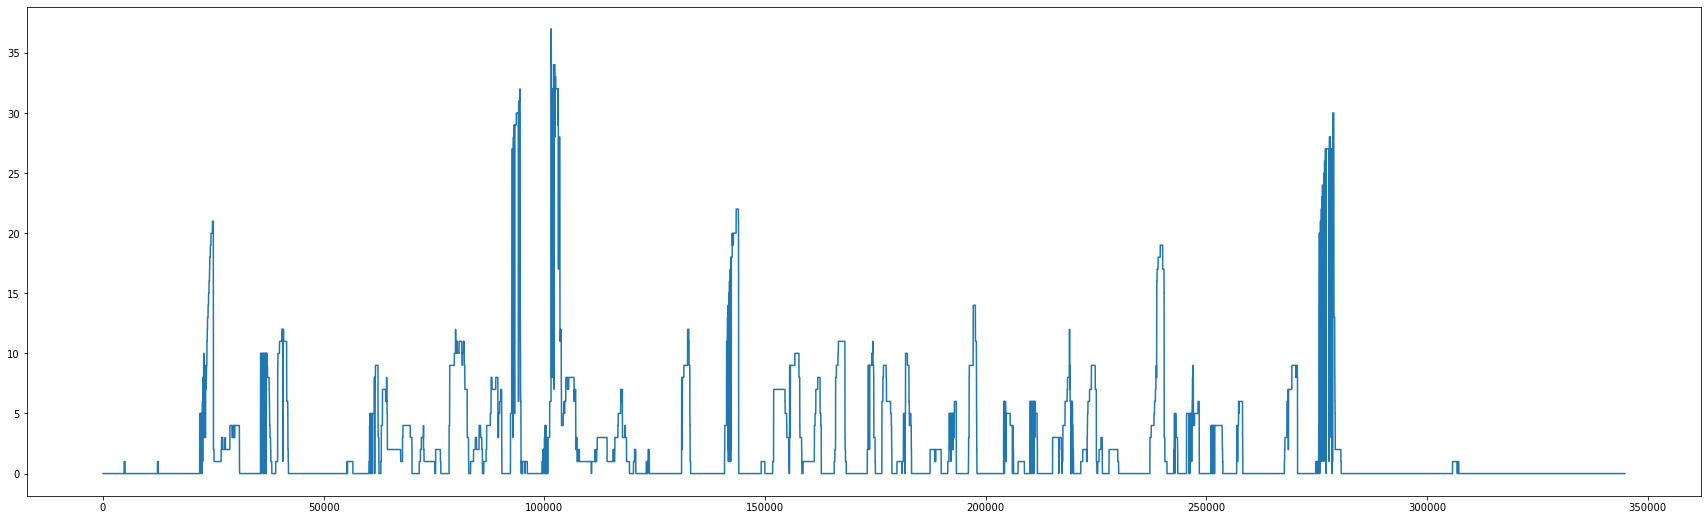

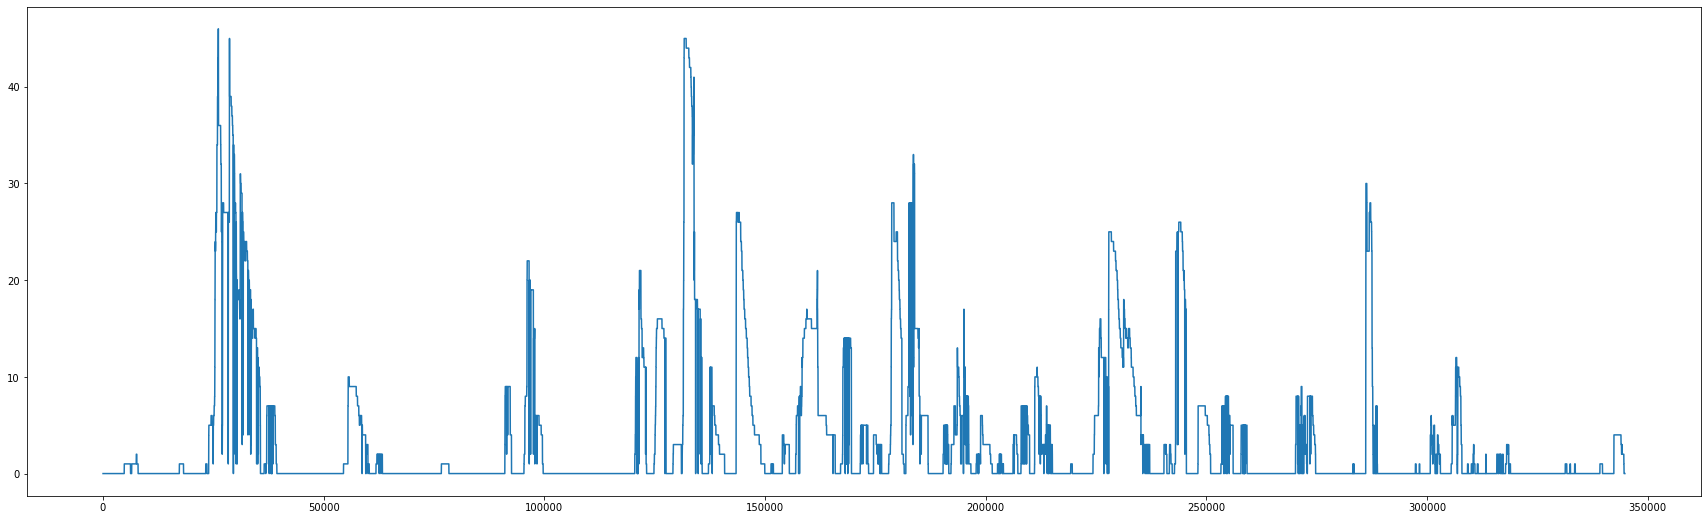

In [7]:
%matplotlib inline
import pysam
import matplotlib.pyplot as plt

minimap2 = pysam.AlignmentFile("minimap2sorted.bam", "rb" )
c = 8 # the contig we want to process; 0 is contig1, 1 is contig2, ..., 8 is contig9

# create an empty array with zeros of size chromosome_length[c]
coveragepositive = [0] * chromosome_length[c]
coveragenegative = [0] * chromosome_length[c]

# iterate over all the positions in chromosome c
for pileupcolumn in minimap2.pileup(chromosome_name[c]):  #, 24000, 24500
    positive = 0
    negative = 0
    positive_del = 0
    negative_del = 0
    # iterate over all the mapped reads that overlap that position
    for pileupread in pileupcolumn.pileups:
        if pileupread.alignment.is_reverse: # is this read mapped on the reverse strand?
            negative += 1
            # check whether the read has a deletion or an "N" in that position, if so, count it
            if pileupread.is_del and pileupread.is_refskip:
                negative_del += 1            
        else:
            positive += 1
            # check whether the read has a deletion or an "N" in that position, if so, count it
            if pileupread.is_del and pileupread.is_refskip:
                positive_del += 1     
    # the coverage is the number of reads mapped in that position minus the number of reads that have a deletion
    coveragepositive[pileupcolumn.pos] = positive - positive_del
    coveragenegative[pileupcolumn.pos] = negative - negative_del
    
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0, chromosome_length[c]), coveragepositive)
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0, chromosome_length[c]), coveragenegative)

Let's zoom in into the region (342000,344845) at the very end (telomere) of this chromosome/contig on the negative strand. This is a very clear gene on the negative strand (see below).

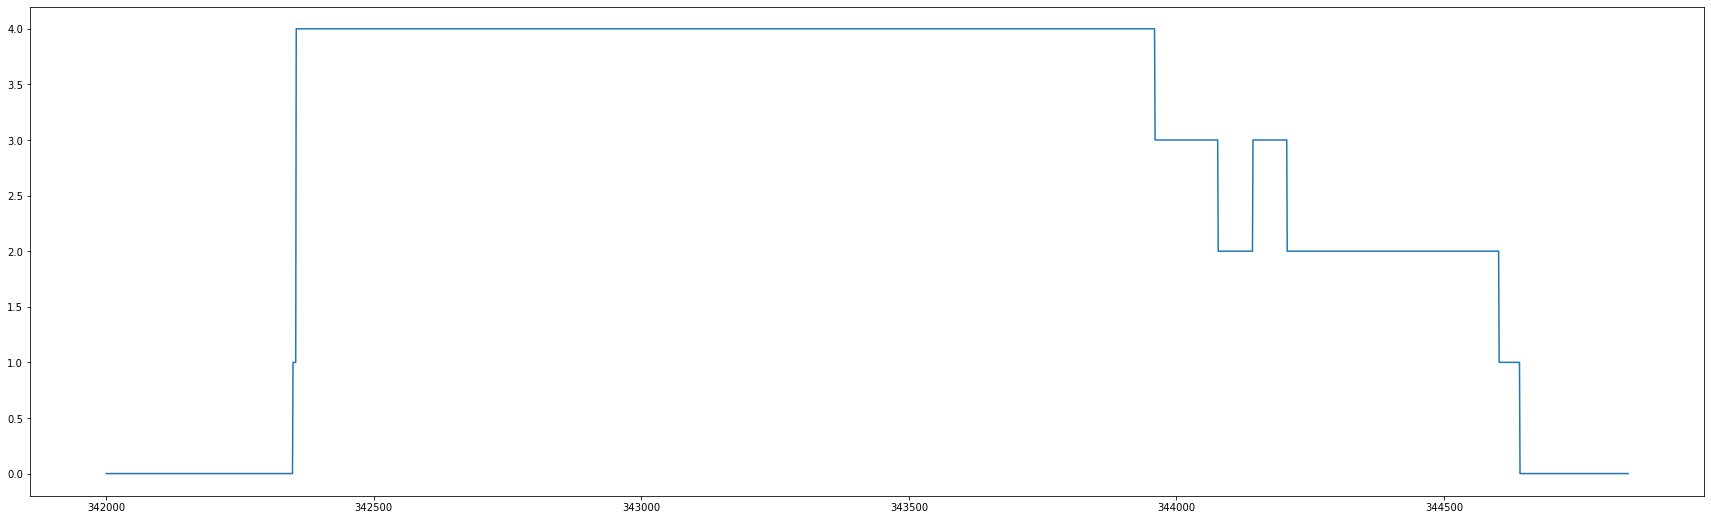

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(30,9))
begin = 342000 
end = 344845
ax.plot(range(begin, end), coveragenegative[begin:end])

The other telomeric region (21000,36000) on this chromosome/contig is more complex.

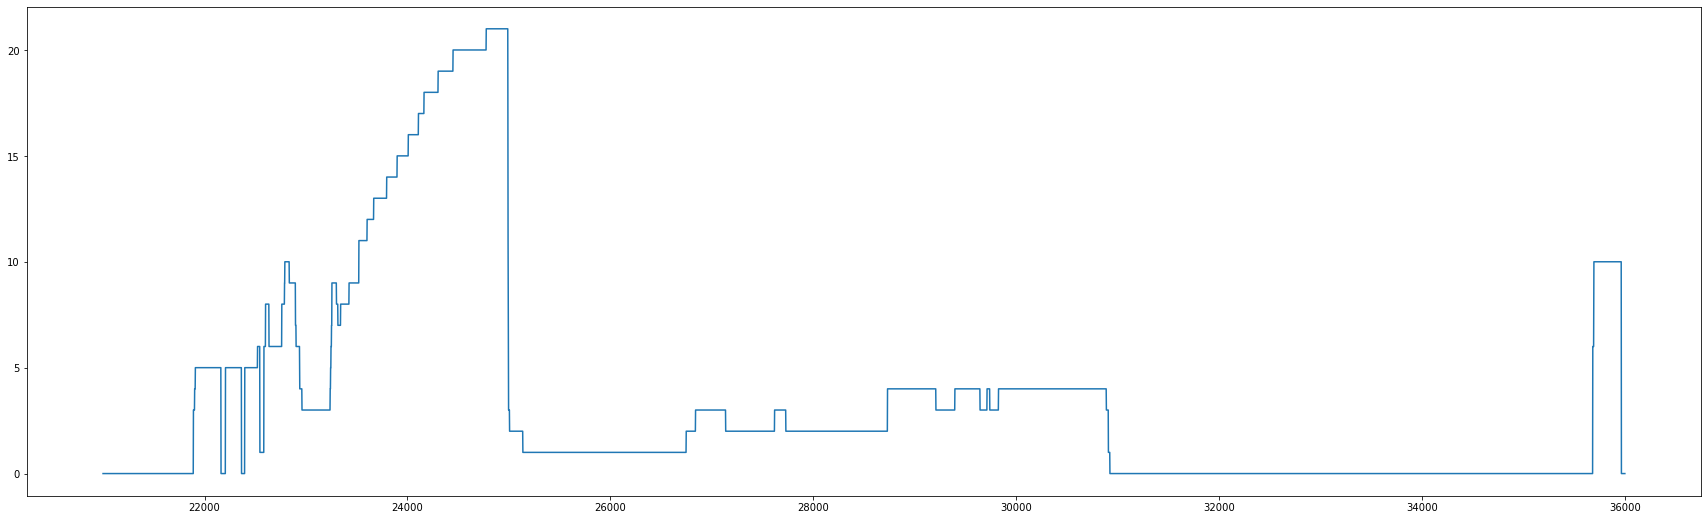

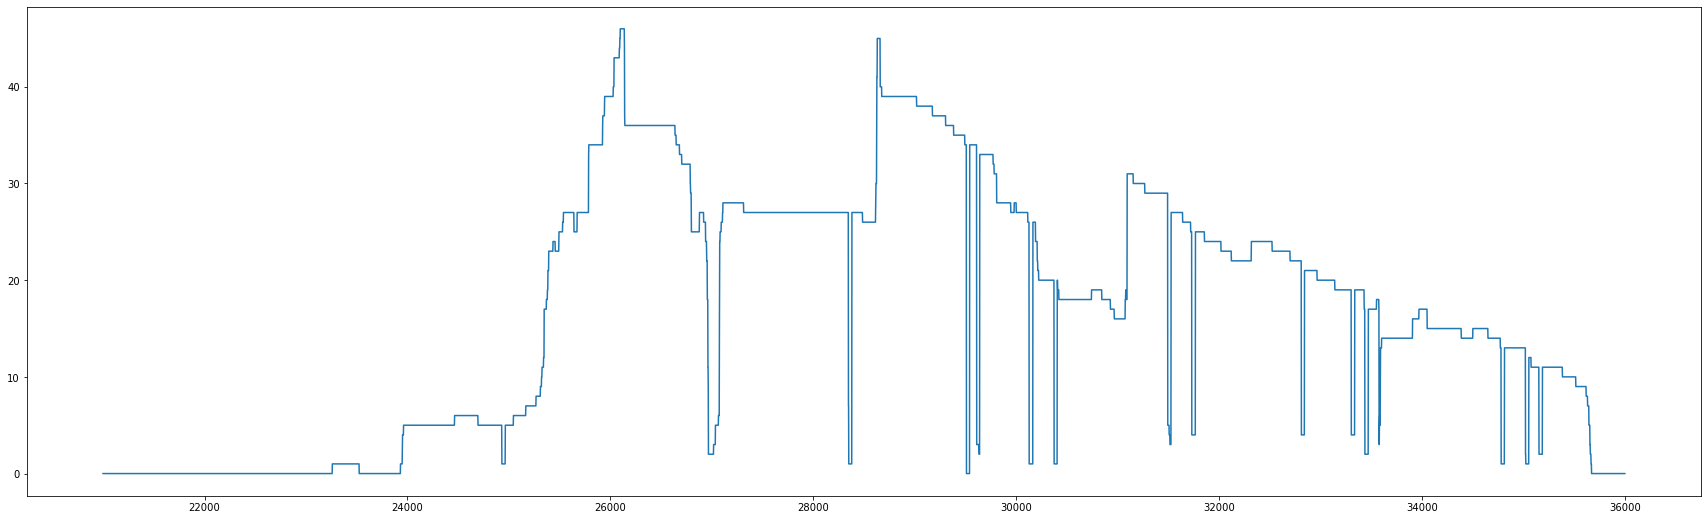

In [9]:
%matplotlib inline
begin = 21000 
end = 36000
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(begin, end), coveragepositive[begin:end])
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(begin, end), coveragenegative[begin:end])

There is a gene from position approx 21800 to  approx 30900 on the positive strand, while on the negative strand the gene is from approx 23900 to approx 35000.

The idea of this project is to use the coverage histogram to find all the genes in the BD genome. The genes in BD would correspond to genomic regions which are coveread by RNA-Seq reads (since these reads  correspond to mRNA transcripts). Note, however that the coverage can be pretty uneven, and finding the boundaries of the genes is not trivial. Coverage "valleys" inside a genome correspond to introns (which are not present in the transcript) and can confuse your algorithm.

The objective of this project is to come up with an algorithm to process the coverage histogram, and produce the list of predicted genes in the BD genome in all chromosomes/contigs. The output should a tab-separated text file with on gene per line with the format `gene_name`, `contig#`, `start`, `end`, and `strand`. Please note that `start` is always smaller than `end` even when the gene is on the negative strand. For example the following output

    BD.0001  contig1   20543    40105   -
    BD.0002  contig1   60043    65323   +
    BD.0003  contig3  133455   135034   +
    BD.0004  contig5   20344    34124   -
    ...
    
indicates that your method detected a gene `BD.0001` (the name of the gene is arbitrary) on contig1 that starts at position 20543 and ends at position 40105 on the negative strand. Gene `BD.0003` is on contig3, etc.

The position of the genes detected by our pipeline is next. You can use it to test or train your method. If you use it to train it, keep some of this data for testing.

In [10]:
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/genes.txt

--2021-06-06 23:04:38--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/genes.txt
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85767 (84K) [text/plain]
Saving to: ‘genes.txt’

genes.txt           100%[===================>]  83.76K  --.-KB/s    in 0.001s  

2021-06-06 23:04:38 (101 MB/s) - ‘genes.txt’ saved [85767/85767]



In [11]:
!head genes.txt

PB.1	contig1	91	1306	-
PB.2	contig1	7615	9514	+
PB.3	contig1	11808	13179	+
PB.4	contig1	13688	19313	+
PB.5	contig1	6353	26539	-
PB.6	contig1	29069	34410	+
PB.7	contig1	34674	35924	+
PB.8	contig1	36026	37778	+
PB.9	contig1	38677	40402	+
PB.10	contig1	41303	44207	+


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set() 

This is just some visualization of the values to get an idea of the data.

In [13]:
dfp = pd.DataFrame(coveragepositive)
dfn = pd.DataFrame(coveragenegative)

<AxesSubplot:xlabel='0'>

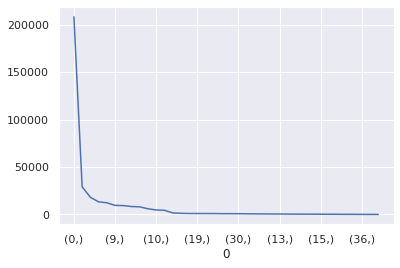

In [14]:
(dfp.value_counts()).plot()

<AxesSubplot:xlabel='0'>

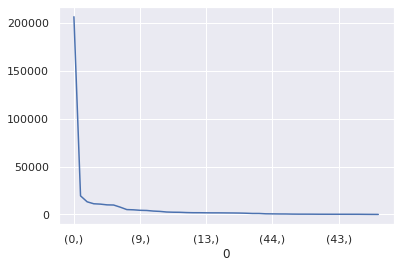

In [15]:
(dfn.value_counts()).plot()

I decided to use HMMs in this project. In an attempt to minimize the number of emissions, I transformed the values to logs.

In [16]:
def log_trans(df):
    #+1 so when -inf is replaced with 0, log(1) is separate from log(0)
    df['log'] = np.log2(df[0]) + 1
    df['log'].replace(-np.inf,0,inplace=True)
    #converting to integers to keep states minimal
    df['log'] = np.ceil(df['log'])
    df['log'] = df['log'].apply(lambda x: np.int(x))
    
    return df

In [17]:
log_trans(dfp)
log_trans(dfn)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0,log
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
344840,0,0
344841,0,0
344842,0,0
344843,0,0


In [18]:
dfp['log'].value_counts()

0    208400
4     31538
1     29144
3     25519
5     21307
2     18063
6     10384
7       490
Name: log, dtype: int64

<AxesSubplot:>

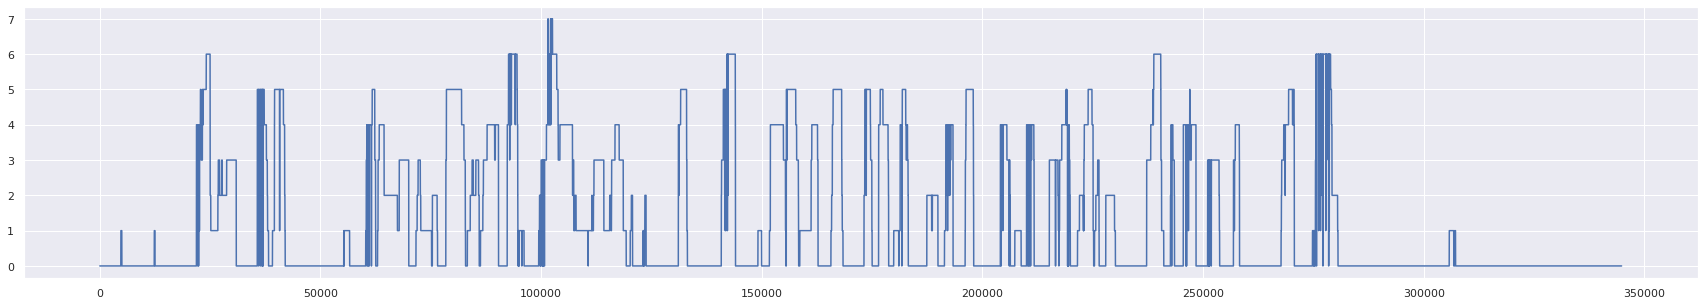

In [19]:
dfp['log'].plot(figsize=(30,5))

In [20]:
# dfn['log'].plot(figsize=(20,10), xlim=(342000, 344845))

In [21]:
from hmmlearn import hmm

In [22]:
# emissions = dfn['log'].to_numpy()
# model_learn = hmm.MultinomialHMM(n_components=2,n_iter=100)
# reshaped = emissions.reshape(1,-1)
# model_learn.fit(reshaped)

# prediction = model_learn.predict(emissions.reshape(-1,1))

# print(model_learn.emissionprob_)

# found = []
# first = 0
# last = 0
# prev_char = 1
# for i in range(len(prediction)):
#     if prediction[i] == 0:
#         if prev_char == 1:
#             first = i
#     if prediction[i] == 1:
#         if prev_char == 0:
#             last = i
#             found.append((first,last))
#     prev_char = prediction[i]
    
# # found = []
# # first = 0
# # last = 0
# # prev_char = 0
# # for i in range(len(prediction)):
# #     if prediction[i] == 1:
# #         if prev_char == 0:
# #             first = i
# #     if prediction[i] == 0:
# #         if prev_char == 1:
# #             last = i
# #             found.append((first,last))
# #     prev_char = prediction[i]

# print(len(prediction) * 0.001)

# genes = []
# with open("genes-Copy1.txt", 'r') as f:
#     for line in f:
#         vals = line.split('\t')
#         gene = (int(vals[2]),int(vals[3]))
#         genes.append(gene)
        
# #genes = genes_all['contig9+']

# merges = []
# prev_gene = found[0]
# error = len(prediction) * 0.001
# for gene in found[1:]:
#     if gene[0] - prev_gene[1] < error:
#         merged = (prev_gene[0], gene[1])
#         prev_gene = merged
#     else:
#         merges.append(prev_gene)
#         prev_gene = gene
# merges.append(prev_gene)

# def rse(first, second):
#     diff0 = np.sqrt((second[0] - first[0]) ** 2)
#     diff1 = np.sqrt((second[1] - first[1]) ** 2)
    
#     return diff0 + diff1

# chrom_len = chromosome_length[c]

# # for merge, gene in zip(merges, genes):
# #     print(merge, '|', gene, 'RSE:', rse(merge, gene))

In [23]:
#create 4 bit vectors
#one corresponds to the genes I found
#one corresponds to the test gene dataset
#one is the intersection of the two
#one is the union of the two
#score is calculated as # of intersections that agree with the union, divided by the length of the contig
def accuracy(chrom_len, merges, genes):
    result = [0] * chrom_len
    test = [0] * chrom_len
    bit_i = [0] * chrom_len
    bit_u = [0] * chrom_len
    for merge in merges:
        for pos in range(merge[0], merge[1]):
            result[pos] = 1
    for gene in genes:
        for pos in range(gene[0], gene[1]):
            test[pos] = 1

    for i in range(chrom_len):
        if (result[i] == 1) or (test[i] == 1):
            bit_u[i] = 1
            if (result[i] == 1) and (test[i] == 1):
                bit_i[i] = 1

    score = 0
    for pos1, pos2 in zip(bit_i, bit_u):
        if pos1 == pos2:
            score += 1
    return (score/chrom_len)

In [24]:
#function to generate gene ranges from the predicted states
def intervals(state1, state2, prediction):
    found = []
    first = 0
    last = 0
    prev_char = state1
    for i in range(len(prediction)):
        if prediction[i] == state2:
            if prev_char == state1:
                first = i
        if prediction[i] == state1:
            if prev_char == state2:
                last = i
                found.append((first,last))
        prev_char = prediction[i]
    return found

In [25]:
#parsing the given genes.txt
genes_all = {}
with open("genes.txt", 'r') as f:
    for line in f:
        vals = line.split('\t')
        contign = vals[1]
        strand = vals[4].strip()
        contigns = contign + strand
        gene = (int(vals[2]),int(vals[3]))
        if genes_all.get(contigns) is None:
            genes_all[contigns] = []
        genes_all[contigns].append(gene)

In [26]:
# print(genes_all['contig9-'])
# print('contigs =', chromosome_name)
# print('lengths (bp) =', chromosome_length)

In [27]:
#minimap2 = pysam.AlignmentFile("minimap2sorted.bam", "rb" )

contigs = {}

scores = []

# the contig we want to process; 0 is contig1, 1 is contig2, ..., 8 is contig9
for c in range(0,8):
    # create an empty array with zeros of size chromosome_length[c]
    coveragepositive = [0] * chromosome_length[c]
    coveragenegative = [0] * chromosome_length[c]

    # iterate over all the positions in chromosome c
    for pileupcolumn in minimap2.pileup(chromosome_name[c]):  #, 24000, 24500
        positive = 0
        negative = 0
        positive_del = 0
        negative_del = 0
        # iterate over all the mapped reads that overlap that position
        for pileupread in pileupcolumn.pileups:
            if pileupread.alignment.is_reverse: # is this read mapped on the reverse strand?
                negative += 1
                # check whether the read has a deletion or an "N" in that position, if so, count it
                if pileupread.is_del and pileupread.is_refskip:
                    negative_del += 1            
            else:
                positive += 1
                # check whether the read has a deletion or an "N" in that position, if so, count it
                if pileupread.is_del and pileupread.is_refskip:
                    positive_del += 1     
        # the coverage is the number of reads mapped in that position minus the number of reads that have a deletion
        coveragepositive[pileupcolumn.pos] = positive - positive_del
        coveragenegative[pileupcolumn.pos] = negative - negative_del
    contigs[chromosome_name[c] + '+'] = coveragepositive
    contigs[chromosome_name[c] + '-'] = coveragenegative
    
    
    strands = [chromosome_name[c] + '+', chromosome_name[c] + '-']
    
    df = pd.DataFrame(contigs[strands[0]])
    log_trans(df)
    
    for strand in strands:
        df = pd.DataFrame(contigs[strand])
        log_trans(df)
    
        #training HMM
        emissions = df['log'].to_numpy()
        model_learn = hmm.MultinomialHMM(n_components=2,n_iter=100)
        reshaped = emissions.reshape(1,-1)
        model_learn.fit(reshaped)
    
        #predicting on strand
        prediction = model_learn.predict(emissions.reshape(-1,1))
    
        #find corresponding genes from genes.txt
        genes = genes_all[strand]
        
        #the gene can be randomly state 1 or state 0, so both are checked
        found1 = intervals(0, 1, prediction)
        found2 = intervals(1, 0, prediction)
        
        founds = [found1, found2]
        
        accuracies = []

        for found in founds:
            merges = []
            prev_gene = found[0]
            #merging ranges together if the distance between them is smaller than 0.1% of the contig length
            error = len(prediction) * 0.001
            for gene in found[1:]:
                if gene[0] - prev_gene[1] < error:
                    merged = (prev_gene[0], gene[1])
                    prev_gene = merged
                else:
                    merges.append(prev_gene)
                    prev_gene = gene
            merges.append(prev_gene)
            accuracies.append(accuracy(chromosome_length[c],merges,genes))
        scores.append((strand, max(accuracies)))

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)

In [28]:
for score in scores:
    print(score)

('contig1+', 0.803808466931039)
('contig1-', 0.8981976072656147)
('contig2+', 0.8715347144367738)
('contig2-', 0.7796397292490285)
('contig3+', 0.7770706284855311)
('contig3-', 0.8671552787949867)
('contig4+', 0.8637487446742879)
('contig4-', 0.7912564389801536)
('contig5+', 0.8715516317890295)
('contig5-', 0.8784786425899964)
('contig6+', 0.8054018014720301)
('contig6-', 0.9079994247839671)
('contig7+', 0.8964721639860691)
('contig7-', 0.7777911335001585)
('contig8+', 0.805165175506764)
('contig8-', 0.8687046733079734)


In [ ]:
minimap2.close()
!rm -f minimap2* BD.* transcripts* genes.txt 2>/dev/null # uncomment this to clean up your directory